In [36]:
import pandas as pd
import numpy as np

from src.models.classification import model_selector#, create_objective

import matplotlib.pyplot as plt
import seaborn as sns

from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import mode
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import randint, uniform
from sklearn.model_selection import cross_val_score

import warnings



warnings.filterwarnings("ignore")


print("starting")
# Load data
csv_path = "C:\\Users\\tania\\OneDrive\\Bureau\\M2\\DATA_challenge\\classif\\"
train_df = pd.read_csv(csv_path + "train_data.csv")
test_df = pd.read_csv(csv_path + "test_data.csv")

# Save row_id for submission
test_ids = test_df["row_id"]

# Drop row_id from both
X_train = train_df.drop(columns=["reservation_status","Unnamed: 0","row_id"])
y_train = train_df["reservation_status"]
X_test = test_df.copy()


starting


In [37]:
#### TRAIN feature engineering

# categorisation of the year variable
X_train['arrival_date_year'] = X_train['arrival_date_year'].astype('category')

# new variables
off_season=["February", "December", "November", "January"] 
X_train["off_season"]=  X_train["arrival_date_month"].isin(off_season).astype(int)
X_train["expensive"]=(X_train['adr'] > X_train['adr'].mean()+X_train['adr'].std()).astype(int)
X_train["cheap"]=(X_train['adr'] > X_train['adr'].mean()+X_train['adr'].std()).astype(int)
X_train["weekend"]=((X_train['stays_in_week_nights'] == 0) & (X_train['stays_in_weekend_nights']>0)).astype(int)

# get 0 2 1 =90+%  3 and higher as one  and get 0 1 2 3 4 5 =90+%  6 and higher as one
X_train["long_wk_stays"]=(X_train['stays_in_week_nights']>=6).astype(int) 
X_train["long_wkd_stays"]=(X_train['stays_in_weekend_nights']>=3).astype(int) 

# COS SIN Transformation for cyclical Variables 
month_map = {
    "January": 1, "February": 2, "March": 3, "April": 4,
    "May": 5, "June": 6, "July": 7, "August": 8,
    "September": 9, "October": 10, "November": 11, "December": 12
}
X_train["arrival_date_month_x"] = np.sin(2 * np.pi * X_train["arrival_date_month"].map(month_map) / 12)
X_train["arrival_date_month_y"] = np.cos(2 * np.pi * X_train["arrival_date_month"].map(month_map) / 12)
X_train["arrival_date_week_number_x"] = np.sin(2 * np.pi * X_train["arrival_date_week_number"] / 52)
X_train["arrival_date_week_number_y"] = np.cos(2 * np.pi * X_train["arrival_date_week_number"] / 52)
X_train["arrival_date_day_of_month_x"] = np.sin(2 * np.pi * X_train["arrival_date_day_of_month"] / 31)
X_train["arrival_date_day_of_month_y"] = np.cos(2 * np.pi * X_train["arrival_date_day_of_month"] / 31)

X_train_with_cyclical_variables_in_double=X_train.copy()
X_train.drop('arrival_date_month', axis=1, inplace=True)
X_train.drop('arrival_date_week_number', axis=1, inplace=True)
X_train.drop('arrival_date_day_of_month', axis=1, inplace=True)



#### TEST feature engineering

# categorisation of the year variable
X_test['arrival_date_year'] = X_test['arrival_date_year'].astype('category')

# new variables
X_test["off_season"]=  X_test["arrival_date_month"].isin(off_season).astype(int)
X_test["expensive"]=(X_test['adr'] > X_test['adr'].mean()+X_test['adr'].std()).astype(int)
X_test["cheap"]=(X_test['adr'] > X_test['adr'].mean()+X_test['adr'].std()).astype(int)
X_test["weekend"]=((X_test['stays_in_week_nights'] == 0) & (X_test['stays_in_weekend_nights']>0)).astype(int)

# get 0 2 1 =90+%  3 and higher as one  and get 0 1 2 3 4 5 =90+%  6 and higher as one
X_test["long_wk_stays"]=(X_test['stays_in_week_nights']>=6).astype(int) 
X_test["long_wkd_stays"]=(X_test['stays_in_weekend_nights']>=3).astype(int) 

# COS SIN Transformation for cyclical Variables 
X_test["arrival_date_month_x"] = np.sin(2 * np.pi * X_test["arrival_date_month"].map(month_map) / 12)
X_test["arrival_date_month_y"] = np.cos(2 * np.pi * X_test["arrival_date_month"].map(month_map) / 12)
X_test["arrival_date_week_number_x"] = np.sin(2 * np.pi * X_test["arrival_date_week_number"] / 52)
X_test["arrival_date_week_number_y"] = np.cos(2 * np.pi * X_test["arrival_date_week_number"] / 52)
X_test["arrival_date_day_of_month_x"] = np.sin(2 * np.pi * X_test["arrival_date_day_of_month"] / 31)
X_test["arrival_date_day_of_month_y"] = np.cos(2 * np.pi * X_test["arrival_date_day_of_month"] / 31)



In [38]:
numerical_cols = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = X_train.select_dtypes(include=["object"]).columns.tolist()

# Remove row_id from numerical if present
if "row_id" in numerical_cols:
    numerical_cols.remove("row_id")

# Preprocessing
numerical_transformer = SimpleImputer(strategy="mean")
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])


preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)


In [ ]:
#model = RandomForestClassifier(random_state=42)
#cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#X_train_with_cyclical_variables_in_double_processed = preprocessor.fit_transform(X_train_with_cyclical_variables_in_double)
#score= cross_val_score(model, X_train_processed, y_train,cv=cv, scoring='f1_weighted').mean()
#score_cycl= cross_val_score(model, X_train_with_cyclical_variables_in_double_processed, y_train,cv=cv, scoring='f1_weighted').mean()#

#print("only sin  cos cyclical : ", score, "cyclical in double : ", score_cycl)

# exactly the same perf => when converting a cyclical feature into trigonometric circle coordinate you can dump the old feature

only sin  cos cyclical :  0.8712831403210386 cyclical double :  0.8712831403210386


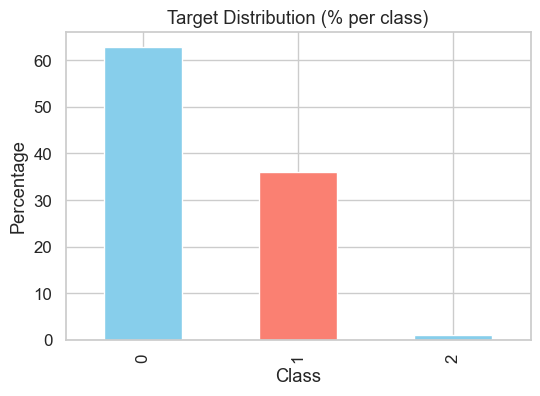

In [40]:
# nicer colors
sns.set(style="whitegrid", font_scale=1.1)
#barplot  target distribution 
plt.figure(figsize=(6,4))
y_train.value_counts(normalize=True).mul(100).plot(kind='bar', color=['skyblue','salmon'])
plt.title("Target Distribution (% per class)")
plt.ylabel("Percentage")
plt.xlabel("Class")
plt.show()

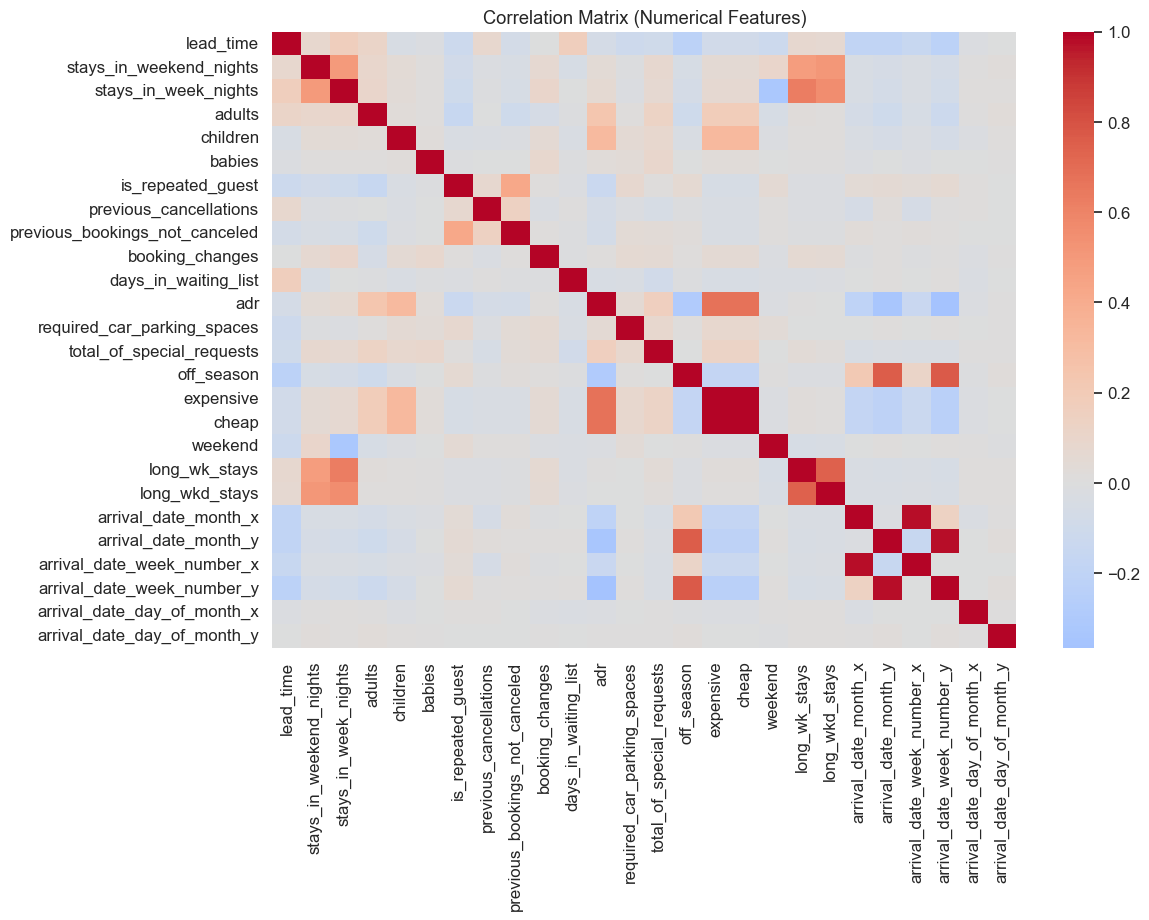

In [41]:
# Correlation matrix ( heatmap )
plt.figure(figsize=(12,8))
corr = X_train.corr(numeric_only=True)
sns.heatmap(corr, cmap='coolwarm', center=0, annot=False)
plt.title("Correlation Matrix (Numerical Features)")
plt.show()

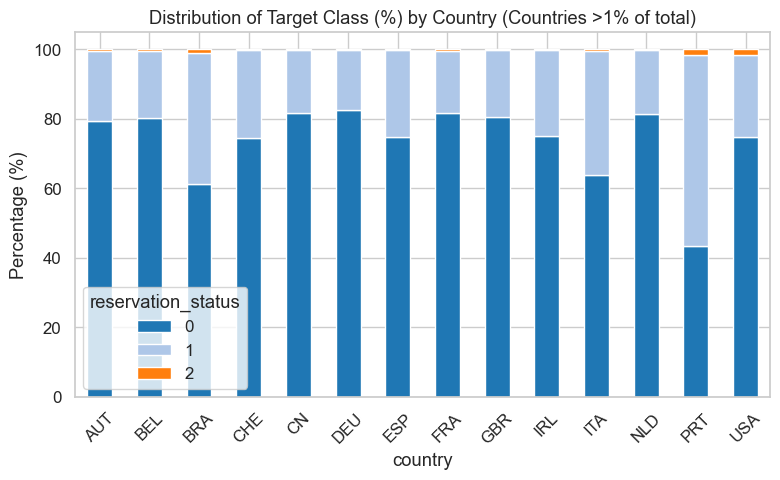

Countries representing >1% of samples account for 90.20% of all data.
Index(['PRT', 'GBR', 'FRA', 'ESP', 'DEU', 'ITA', 'IRL', 'BEL', 'BRA', 'USA',
       'NLD', 'CHE', 'CN', 'AUT'],
      dtype='object', name='country') country
PRT    40.863305
GBR    10.245580
FRA     8.779645
ESP     7.172922
DEU     6.183053
ITA     3.153938
IRL     2.818659
BEL     1.947807
BRA     1.865076
USA     1.805568
NLD     1.730094
CHE     1.470289
CN      1.092920
AUT     1.071149
Name: proportion, dtype: float64


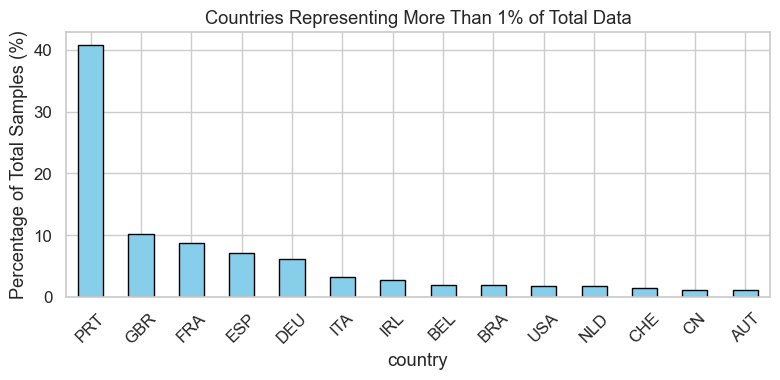

 Mean percentage of each target class across all common countries:
reservation_status
0    73.944411
1    25.514334
2     0.541255
dtype: float64


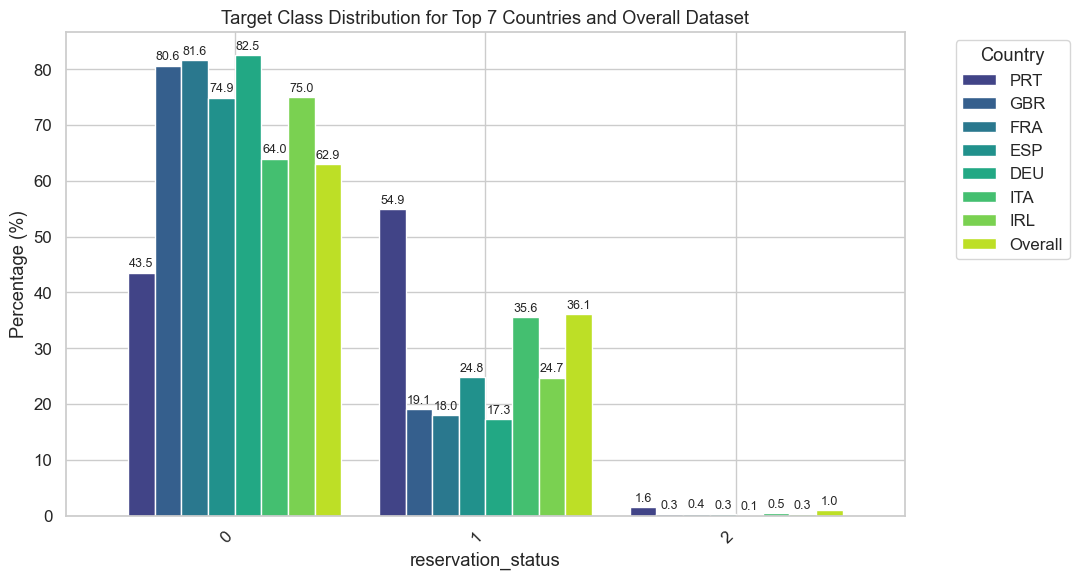

In [42]:
# Compute how often each country appears (as % of all rows)
country_counts = X_train["country"].value_counts(normalize=True) * 100

# Keep only those countries that represent >1% of total samples
common_countries_names = country_counts[country_counts > 1].index
common_countries = country_counts[country_counts > 1]

# Filter the data to include only those countries
X_train_filtered = X_train[X_train["country"].isin(common_countries_names)]
y_train_filtered = y_train.loc[X_train_filtered.index]

# Create the normalized crosstab (% distribution of target within each country)
ct = pd.crosstab(X_train_filtered["country"], y_train_filtered, normalize='index') * 100

# Plot
palette = plt.get_cmap('tab20').colors  # You can replace with your custom palette
ct.plot(kind='bar', stacked=True, color=palette, figsize=(8,5))
plt.ylabel("Percentage (%)")
plt.title("Distribution of Target Class (%) by Country (Countries >1% of total)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#  Compute how much of the total data these common countries represent
total_pct_common = country_counts[country_counts > 1].sum()
print(f"Countries representing >1% of samples account for {total_pct_common:.2f}% of all data.")

print(common_countries_names,country_counts[country_counts > 1])

plt.figure(figsize=(8,4))
common_countries.sort_values(ascending=False).plot(kind='bar', color='skyblue', edgecolor='black')
plt.ylabel("Percentage of Total Samples (%)")
plt.title("Countries Representing More Than 1% of Total Data")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



mean_target_pct = ct.mean().sort_values(ascending=False)
print(" Mean percentage of each target class across all common countries:")
print(mean_target_pct)


#  Get top 7 most frequent countries
top7_countries = common_countries.sort_values(ascending=False).head(7).index
top7_target_pct = ct.loc[top7_countries]

# Compute overall target distribution (% in y_train)
overall_target_dist = y_train.value_counts(normalize=True) * 100
overall_target_dist.name = "Overall"

# Align overall distribution with same target class order as in ct
overall_target_dist = overall_target_dist.reindex(ct.columns, fill_value=0)

#  Add overall distribution as an additional row to compare
top7_plus_overall = pd.concat([top7_target_pct, overall_target_dist.to_frame().T])

#  Plot
fig, ax = plt.subplots(figsize=(11,6))
colors = plt.get_cmap('viridis')(np.linspace(0.2, 0.9, len(top7_plus_overall)))

top7_plus_overall.T.plot(kind='bar', ax=ax, color=colors, width=0.85)

# Style the plot
plt.ylabel("Percentage (%)")
plt.title("Target Class Distribution for Top 7 Countries and Overall Dataset")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Country", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Add percentage labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f', label_type='edge', fontsize=9, padding=2)

plt.show()

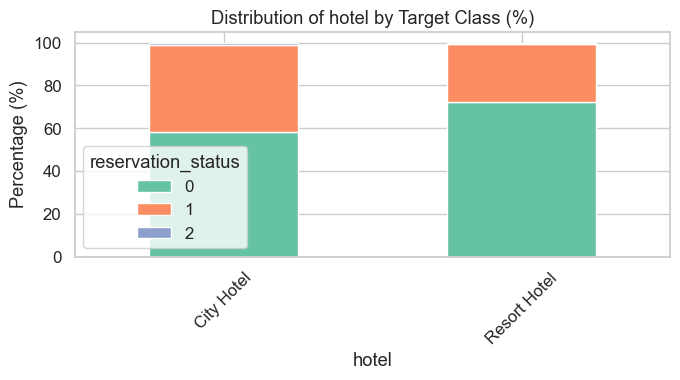

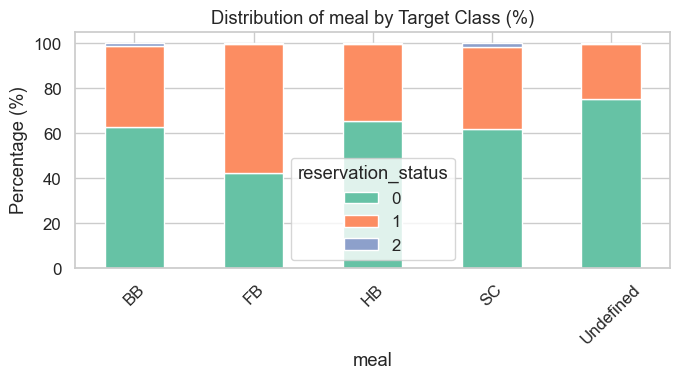

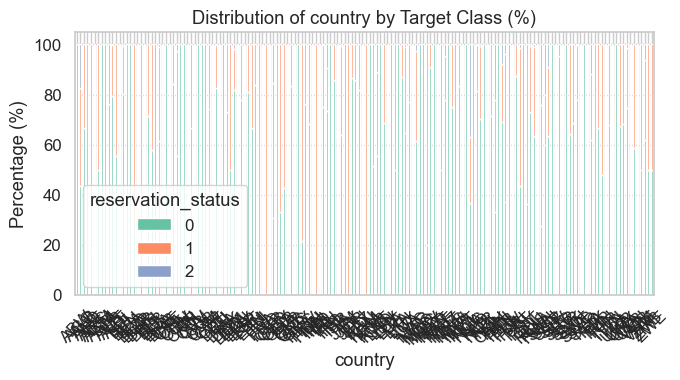

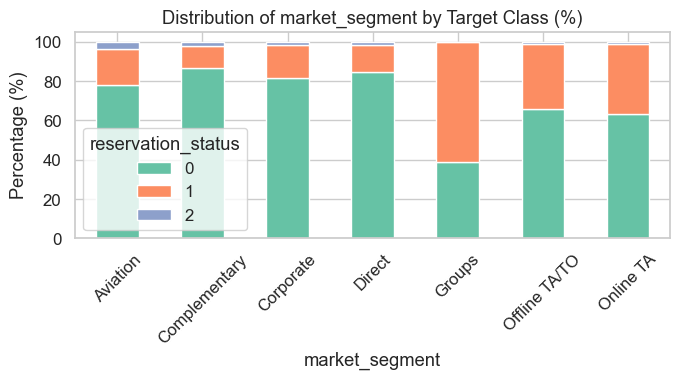

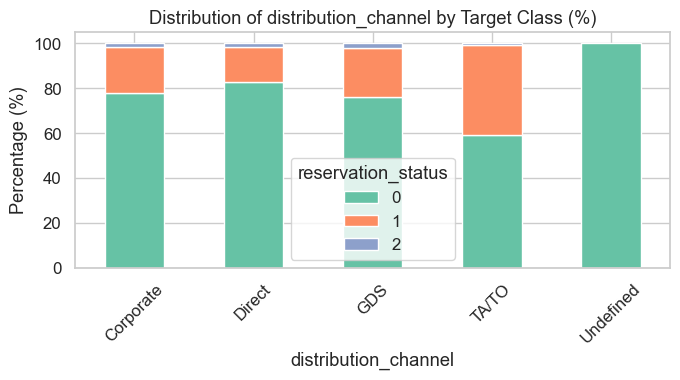

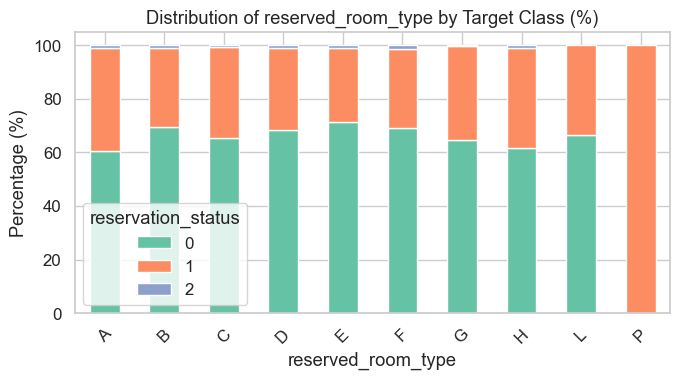

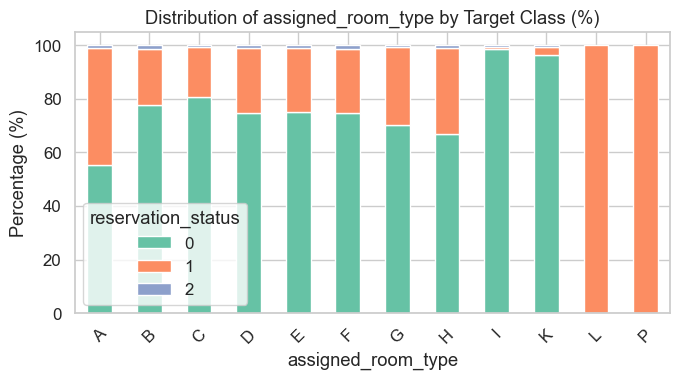

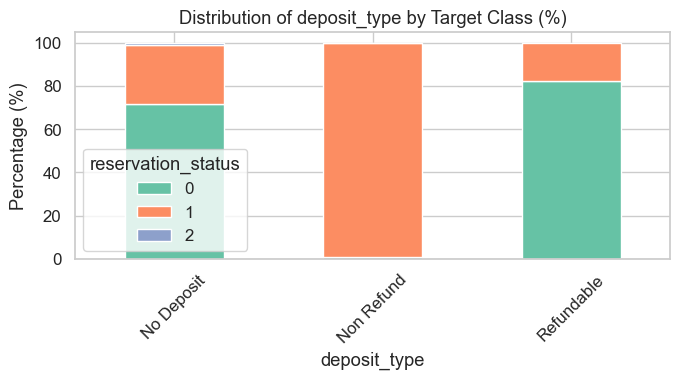

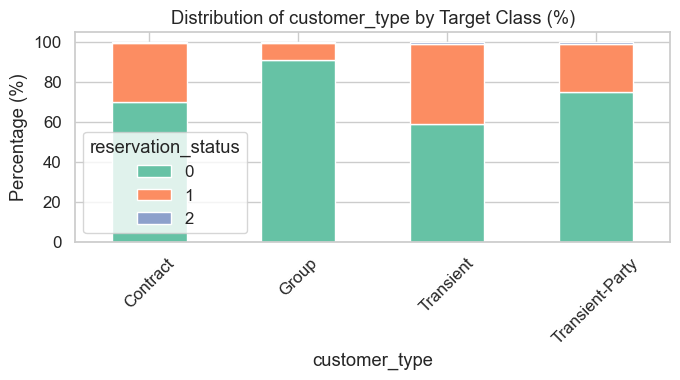

In [43]:
#Histograms for categorical variables grouped by target
numerical_list = X_train[["adr","lead_time"]]
categorical_list = X_train.select_dtypes(include=["object"]).columns.tolist()
palette = sns.color_palette("Set2")
for col in categorical_list:
    ct = pd.crosstab(X_train[col], y_train, normalize='index') * 100
    ct.plot(kind='bar', stacked=True, color=palette, figsize=(7,4))
    plt.ylabel("Percentage (%)")
    plt.title(f"Distribution of {col} by Target Class (%)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

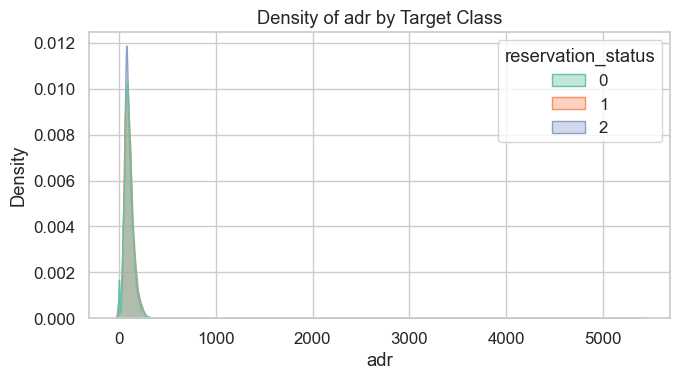

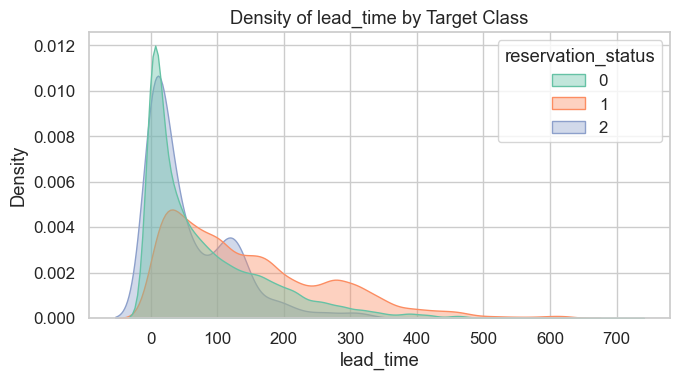

In [44]:
# Density plots for numerical variables by target class
for col in numerical_list:
    plt.figure(figsize=(7,4))
    sns.kdeplot(data=X_train, x=col, hue=y_train, common_norm=False, fill=True, alpha=0.4, palette=palette)
    plt.title(f"Density of {col} by Target Class")
    plt.tight_layout()
    plt.show()

In [46]:
# No-show rate for specific conditions
df_train = X_train.copy()
df_train['target'] = y_train.values

# wkd wk
rate_wkd = df_train.loc[(df_train['stays_in_weekend_nights'] > 0) & (df_train['stays_in_week_nights'] == 0), 'target'].mean()
rate_wk = df_train.loc[(df_train['stays_in_week_nights'] > 0) & (df_train['stays_in_weekend_nights']==0), 'target'].mean()
rate_wk_and_wkd = df_train.loc[(df_train['stays_in_week_nights'] > 0) & (df_train['stays_in_weekend_nights']>0), 'target'].mean()
print(f"No-show rate during weekend : {rate_wkd:.2%}, and during week: {rate_wk:.2%}, and if staying both during the week and weekend : {rate_wk_and_wkd:.2%}")

# off season
rate_off = df_train.loc[(df_train["off_season"] == 1), 'target'].mean()
rate_on = df_train.loc[(df_train["off_season"] == 0), 'target'].mean()
print(f"No-show rate when off_season : {rate_off:.2%}, and when on season : {rate_on:.2%}")

No-show rate during weekend : 27.60%, and during week: 39.12%, and if staying both during the week and weekend : 38.71%
No-show rate when off_season : 34.63%, and when on season : 39.06%



 No-show rate by Year (%):
arrival_date_year
2015    37.81
2016    37.07
2017    39.54
Name: target, dtype: float64


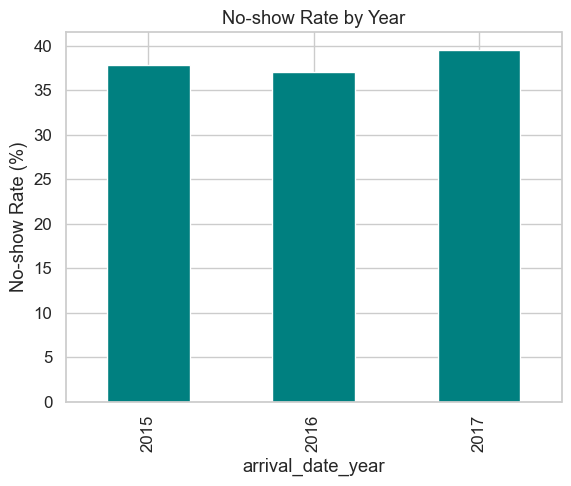

In [49]:
# No-show rate by Year and by Month
if 'arrival_date_year' in df_train.columns:
    rate_by_year = df_train.groupby('arrival_date_year')['target'].mean() * 100
    print("\n No-show rate by Year (%):")
    print(rate_by_year.round(2))
    rate_by_year.plot(kind='bar', title='No-show Rate by Year', color='teal')
    plt.ylabel("No-show Rate (%)")
    plt.show()

if 'arrival_date_month' in df_train.columns:
    rate_by_month = df_train.groupby('arrival_date_month')['target'].mean() * 100
    print("\n No-show rate by Month (%):")
    print(rate_by_month.round(2))
    rate_by_month.plot(kind='bar', title='No-show Rate by Month', color='orange')
    plt.ylabel("No-show Rate (%)")
    plt.show()

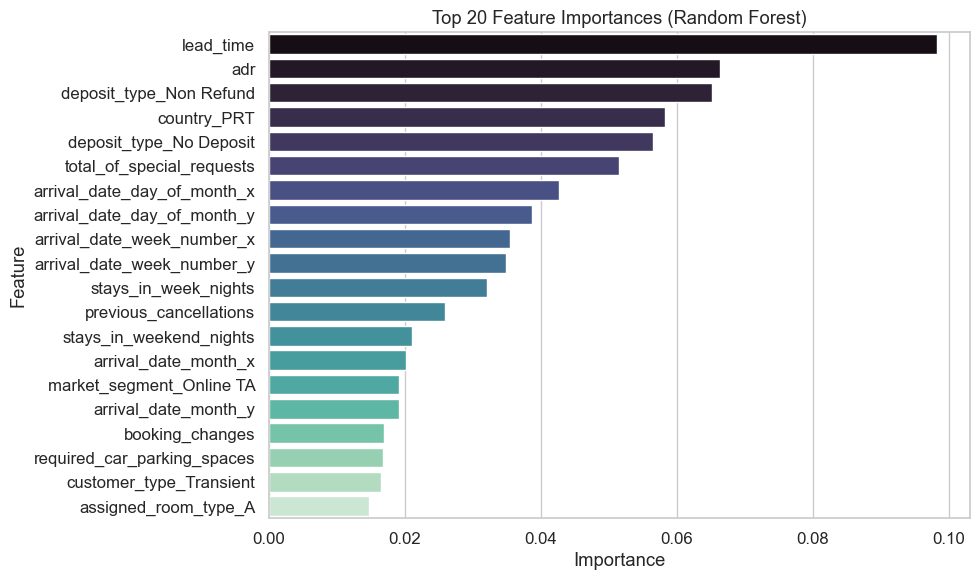

In [50]:
#Feature Importance from LightGBM and RandomForest
# RandomForest
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf.fit(X_train_processed, y_train)

# get X_train.columns with sparse matrix X_train
feature_names = numerical_cols.copy()
ohe = preprocessor.named_transformers_["cat"]
cat_feature_names = ohe.get_feature_names_out(categorical_cols)
feature_names.extend(cat_feature_names)

rf_importances = pd.Series(rf.feature_importances_, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=rf_importances.head(20), y=rf_importances.head(20).index, palette="mako")
plt.title("Top 20 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [51]:
print(y_train[((X_train["adults"] == 0) & (X_train["children"]==0) & (X_train["babies"]==0))].value_counts())
# adults = 0 => 176*0 + 53*1
# only children 87*0 + 44*1 of which 2 are children with babies that did check out
# children+adult+babies=0 => 89*0 + 9*1 

reservation_status
0    89
1     9
Name: count, dtype: int64


In [53]:
#print(X_train['arrival_date_year'].value_counts(normalize=True) * 100) 
# .unique() =2016-47% 2017-34% 2015-18%
#print(X_train['arrival_date_month'].value_counts(normalize=True) * 100) 
# .unique() = all months
# august, july, may, june, april, october, september, march 8-11% of dataset
# february, december, november, january 4-6 % of dataset

In [54]:
# meal BB-77% HB-12% SC-8% NA FB 
#  country (162!=) PRT 40  GBR 10 FRA 8.8 ESP 7.2 DEU 6.2 ITA 3.2 IRL 2.8 BEL 1.9 BRA 1.9 USA 1.8 NLD 1.7 CHE 1.5 CN 1.1 AUT 1.1
# 14=90%
#  market_segment 'Offline TA/TO' 'Groups' 'Online TA' 'Direct' 'Corporate' 'Complementary' 'Aviation'
#  47 20 16 10 4 0.6 0.2 %
# distribution_channel 'TA/TO' 'Direct' 'Corporate' 'GDS' 'Undefined'
# 82 12 5 0.12 0.0014  %
# is_repeated_guest 0-96.8% 1-3.1%
# previous_cancellations 0-94% 1-5% => reste des classes
# previous_bookings_not_canceled 0-97% 1-1.2% => reste des classes
# reserved_room_type 10, A-71% D-16% E-5%  +reste des classes
# assigned_room_type 10, A-61% D-21% E-6%  +reste des classes
# booking_changes 0-84.9 1-10.6 2-3.15 => reste des classes
# deposit_type No Deposit-87.580191 // Non Refund-12.273215 // Refundable-0.146594
# days_in_waiting_list => 97%=0 and reste des classes
# customer_type   Transient 75  Transient-Party 21  Contract 3  Group 0.49 
# required_car_parking_spaces 0-93% 1-6% => reste des classes
# total_of_special_requests 0-58 1-27 2-10 => reste des classes
# adr mean 102, std 52, -2=>0 +2=>2528, -1=>6581 +1=>8773 => expensive and cheap,   1128 where adr=0 
# target = reservation status : # 0 - 62.940869   1 - 36.066359   2 - 0.992772

In [ ]:
### GREEDY FEATURE SEARCH ###


model=RandomForestClassifier(random_state=42)
import xgboost as xgb
features=X_train.columns
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# sequential feature selection with cross validation 
def greedy_feature_selection(X, y, features, cv, model=None, min_improvement=0.001):
    if model is None:
        model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

    selected_features = []
    previous_score = 0
    

    for feature in features:
        candidate_features = selected_features + [feature]
        X_candidate = X[candidate_features]
 
        num_cols = [col for col in X_candidate.columns if col in numerical_cols]
        cat_cols = [col for col in X_candidate.columns if col in categorical_cols]
        numerical_transformer = SimpleImputer(strategy="mean")
        categorical_transformer = Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("encoder", OneHotEncoder(handle_unknown="ignore"))
        ])
        # Build temporary preprocessor for current feature set
        temp_preprocessor = ColumnTransformer(
            transformers=[
                ("num", numerical_transformer, num_cols),
                ("cat", categorical_transformer, cat_cols),
            ]
        )

        # Create a Pipeline so preprocessing and model training happen together during CV
        pipe = Pipeline(steps=[
            ("preprocessor", temp_preprocessor),
            ("model", model)
        ])

        #Perform cross-validation on the pipeline
        cv_score = np.mean(
            cross_val_score(
                pipe,
                X_candidate,
                y,
                cv=cv,
                scoring="f1_weighted",
                n_jobs=-1
            )
        )
        print(f"Trying feature: {feature:<30} | CV Score: {cv_score:.5f} | Improvement: {cv_score - previous_score:.5f}")

        if cv_score - previous_score >= min_improvement:
            selected_features.append(feature)
            previous_score = cv_score  # update baseline

    print("\nSelected transformed features:")
    print(selected_features)
    return selected_features

good_features = greedy_feature_selection(X_train, y_train, features=features, cv=kf, model=model)

# xgboost sequential feature selection with cv =>  0.85752
# 'hotel', 'lead_time', 'arrival_date_month', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'meal', 'country', 'market_segment', 'previous_cancellations', 'assigned_room_type', 'booking_changes', 'deposit_type', 'customer_type', 'adr', 'required_car_parking_spaces', 'total_of_special_requests'
# rf => 0.86923   
# 'hotel', 'lead_time', 'arrival_date_month', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'children', 'meal', 'country', 'market_segment', 'distribution_channel', 'previous_cancellations', 'assigned_room_type', 'booking_changes', 'customer_type', 'adr', 'required_car_parking_spaces', 'total_of_special_requests'


In [ ]:
### AFFICHAGE DES CONFUSION MATRIX PR LE ONE VS ALL ###


from sklearn.metrics import confusion_matrix

# one vs all + binary problem 
target_class = 2  
X_train_ova = X_train_processed.copy()
y_train_ova = y_train.copy()
y_train_ova = np.where(y_train_ova == target_class, 1, 0)
X_train_ova_train, X_train_ova_val, y_train_ova_train, y_train_ova_val = train_test_split(
    X_train_ova, 
    y_train_ova,
    test_size=0.2, 
    random_state=42,
    shuffle=True
)
from imblearn.over_sampling import SMOTE
X_train_ova_train , y_train_ova_train = SMOTE(random_state=42).fit_resample(X_train_ova_train, y_train_ova_train)

mask = (y_train != target_class).astype(bool)
mask_np=mask.to_numpy()
X_train_bin = X_train_processed[mask_np, :].copy() 
y_train_bin = y_train[mask].copy()
X_train_bin_train, X_train_bin_val, y_train_bin_train, y_train_bin_val = train_test_split(
    X_train_bin, 
    y_train_bin,
    test_size=0.2, 
    random_state=42,
    shuffle=True
)

#model_ova = RandomForestClassifier(random_state=42,n_estimators=1500, max_depth=20, class_weight={0:1,1:2},min_samples_leaf=2)
 # tweeked above = TP=19, FP=3, TN=13642, FN=116  normal = TP=32, FP=3, TN=13642, FN=103  just weighted TP=37, FP=13, TN=13632, FN=98
# normal shit = TP=32, FP=4, TN=13641, FN=103 *3
model_ova = RandomForestClassifier(random_state=42)
# reweight 1 10 = TP=38, FP=17, TN=13628, FN=97
# 1500 estimators reweighting 1 2 TP=33, FP=5, TN=13640, FN=102   same n est 100 =TP=33, FP=4, TN=13641, FN=102
# minsampleaf reweight2 TP=33, FP=4, TN=13641, FN=102  +maxdepth30 =TP=32, FP=3, TN=13642, FN=103
#model_ova = RandomForestClassifier(random_state=42,class_weight={0:1,1:5})
#model_ova = RandomForestClassifier(
#    n_estimators=300,           # enough trees for stability
#    max_depth=10,               # limits overfitting
#    min_samples_split=2,        # prevents tiny splits
#    min_samples_leaf=1,         # prevents leaves with very few samples
#    max_features='log2',        # typical for classification
#    bootstrap=True,             
#    class_weight={0:1,1:2},    # gives higher weight to minority class  0 FN but 3000 FP
#    random_state=42,            
#    n_jobs=-1   
    # with smote without reweighting TP=13021, FP=588, TN=13185, FN=492
    #OVA Confusion Matrix: TP=14, FP=23, TN=13622, FN=121
#)##OVA Confusion Matrix: TP=79, FP=1424, TN=12221, FN=56
model_bin = RandomForestClassifier(random_state=42)
model_full = RandomForestClassifier(random_state=42)

# ----- Train OVA and compute confusion matrix -----
model_ova.fit(X_train_ova_train, y_train_ova_train)
y_pred_ova = model_ova.predict(X_train_ova_val)

y_proba = model_ova.predict_proba(X_train_ova_val)[:,1]  # positive class probability
threshold = 0.1  # tweak between 0.4–0.5
y_pred = (y_proba >= threshold).astype(int)


tn, fp, fn, tp = confusion_matrix(y_train_ova_val, y_pred).ravel()
print(f"OVA Confusion Matrix: TP={tp}, FP={fp}, TN={tn}, FN={fn}")

tn, fp, fn, tp = confusion_matrix(y_train_ova_val, y_pred_ova).ravel()
print(f"OVA Confusion Matrix: TP={tp}, FP={fp}, TN={tn}, FN={fn}")

# ----- 4️⃣ Cross-validation mean F1 (weighted) -----
#cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#f1_ova = cross_val_score(model_ova, X_train_ova, y_train_ova,
#                         cv=cv, scoring='f1_weighted').mean()
#f1_bin = cross_val_score(model_bin, X_train_bin, y_train_bin,
#                         cv=cv, scoring='f1_weighted').mean()

#print(f"Mean weighted F1 (OVA):   {f1_ova:.4f}")
#print(f"Mean weighted F1 (Binary):{f1_bin:.4f}")

# ----- 5️⃣ Full Random Forest (multi-class) -----
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(
    X_train_processed, 
    y_train,
    test_size=0.2, 
    random_state=42,
    shuffle=True
)
model_full.fit(X_train_train, y_train_train)
y_pred_full = model_full.predict(X_train_val)

# Convert to one-vs-all for target_class
y_true_ova_full = np.where(y_train_val == target_class, 1, 0)
y_pred_ova_full = np.where(y_pred_full == target_class, 1, 0)

tn, fp, fn, tp = confusion_matrix(y_true_ova_full, y_pred_ova_full).ravel()
f1_full_ova = f1_score(y_true_ova_full, y_pred_ova_full, average='weighted')

print(f"\nFull RandomForest one-vs-all performance (class={target_class}):")
print(f"TP={tp}, FP={fp}, TN={tn}, FN={fn}")
print(f"Weighted F1 (OVA on full model): {f1_full_ova:.4f}")

In [ ]:
### Importance plots for each models ###

# get X_train.columns with sparse matrix X_train
feature_names = numerical_cols.copy()
ohe = preprocessor.named_transformers_["cat"]
cat_feature_names = ohe.get_feature_names_out(categorical_cols)
feature_names.extend(cat_feature_names)

model_bin.fit(X_train_bin, y_train_bin)

# OVA
importances_ova = pd.Series(model_ova.feature_importances_, index=feature_names)
print("\nTop 10 OVA feature importances:")
print(importances_ova.sort_values(ascending=False).head(10))
#Top 10 OVA feature importances:
#adr                            0.098989
#lead_time                      0.098093
#arrival_date_day_of_month      0.055331
#arrival_date_day_of_month_x    0.054253
#stays_in_week_nights           0.051245
#arrival_date_day_of_month_y    0.050639
#arrival_date_week_number       0.034657
#arrival_date_week_number_x     0.034476
#arrival_date_week_number_y     0.032414
#stays_in_weekend_nights        0.031016
# date in the month and in the year progression pdv + week end or week stay +  adr and lead time => no deposit no country no special request


# For binary model
importances_bin = pd.Series(model_bin.feature_importances_, index=feature_names)
print("\nTop 10 Binary feature importances:")
print(importances_bin.sort_values(ascending=False).head(10))
#Top 10 Binary feature importances:
#lead_time                      0.094972
#deposit_type_Non Refund        0.068816
#country_PRT                    0.062157
#deposit_type_No Deposit        0.059247
#adr                            0.059079
#total_of_special_requests      0.049972
#arrival_date_day_of_month_x    0.033153
#arrival_date_day_of_month      0.032829
#arrival_date_day_of_month_y    0.029996
#stays_in_week_nights           0.028967


# For full model
importances_full = pd.Series(model_full.feature_importances_, index=feature_names)
print("\nTop 10 Full-model feature importances:")
print(importances_full.sort_values(ascending=False).head(10))

#Top 10 Full-model feature importances:
#lead_time                      0.092050
#deposit_type_No Deposit        0.064398
#deposit_type_Non Refund        0.062880
#adr                            0.059582
#country_PRT                    0.057557
#total_of_special_requests      0.048953
#arrival_date_day_of_month_x    0.034497
#arrival_date_day_of_month      0.033985
#arrival_date_day_of_month_y    0.031201
#stays_in_week_nights           0.029724

